# Project 1: Language Modeling and Fake News Classification

Names: 

Netids: 

**After you make your own copy, please rename this notebook by clicking on it's name in the upper left corner.** It should be named: 4740_FA20_p1_netid1_netid2

Don't forget to share your newly copied notebook with your partner!

**Reminder: both of you can't work in this notebook at the same time from different computers/browser windows because of sync issues. We even suggest to close the tab with this notebook when you are not working on it so your partner doesn't get sync issues.**

## Introduction
In this project we will build an **n-gram-based language model** for fake news classification. We will also investigate a feature-based **Naive Bayes model**. The task we are faced with is to **decide whether a news article is fake or real**. While some fake articles are so absurd and nonsensical that one can clearly guess they are fake, most fake news is actually quite hard to detect. [Various studies](https://pacscenter.stanford.edu/research/program-on-democracy-and-the-internet/deception-detection-accuracy-for-fake-news-headlines-on-social-media/) have shown that most people can have an error rate up to 50% depending on the theme of the article. 

To help us approach this problem, we will use NLP techniques covered thus far to frame this as a (supervised) binary classification task, where each article will have a label $y \in \{0,1\}$, where *0 indicates a real article* and *1 indicates a fake one*. You will train and validate your two different models and then run them on a test data set with hidden $y$ labels. You will then submit the results on the test data set to Kaggle to participate in our class-wide competition!

The project is divided into six parts:
1. Dataset loading and preprocessing
2. Unsmoothed n-gram language model (LM): build the unsmoothed n-gram language model using our Fake News corpus. 
3. Smoothed n-gram language model: build a smoothed version of the model from part 2.
4. Perplexity: compute perplexity for both the unsmoothed and smoothed model
5. Putting everything together and submitting the first model to Kaggle
6. Naive Bayes: build a feature-based Naive Bayes model to perform the same classification task. Compare the LM with Naive Bayes and identify the pros and cons of each.

**Logistics:** You should work in **groups of 2 students**. Students in the same group will get the same grade. Thus, you should make sure that everyone in your group contributes to the project. 
- **Remember to form groups on BOTH CMS and Gradescope** or not all group members will receive grades. You can use the Teammate Search option on Piazza to find a partner for this project.

**Advice:** Please complete the written parts of this notebook in a clear and informative way. This is where you get to show us that you understand not only what you are doing but also why and how you are doing it. So be clear, organized and concise; avoid vagueness and excess verbiage. Spend time
doing error analysis for the models. This is how you understand the advantages and drawbacks of the systems you build. 
- It's also useful to think about how the theory of n-grams/Naive Bayes bridges with the real world application we are building. Think about what you expect from these models based on your current understanding, and then see if your expectation aligns with empirical results that you'll get. 

## General Guidelines
In this project, we provide a few code snippets or starter points in case you need them. You DO NOT need to follow the structure. 

If you think you have a better idea, go for it. You can ADD, MODIFY, or DELETE any code snippets given to you.

**Let's do this** 🚀

### Dataset

You are given a **News Corpus** on CMS, which consists of roughly the same amount of real and fake news articles.

Real news example:
```
The OpenAI technology, known as GPT-2, is designed to predict the next word given all the previous words it is shown within some text. The language-based model has been trained on a dataset of 8 million web pages.
```

Fake news example:
```
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.
```

In the dataset folder you should find 4 files, training and validation splits for both real and fake news.

The project will proceed generally as follows in terms of code development:
1. Write code to train unsmoothed unigram and bigram language models for an arbitrary corpus
2. Implement smoothing and unknown word handling. 
3. Implement the Perplexity calculation. 
4. Using 1, 2 and 3, together with the provided training and validation sets, develop a language-model-based approach for Fake News Classification.
5. Apply your best language-model-based news classifier (from 4) to the
provided test set. Submit the results to the online Kaggle competition. 
6. Use any existing implementation of Naive Bayes (and the provided training and validation sets) to create an additional Naive Bayes fake news classifier. Apply your best NB classifier to the provided test set. Submit the results to the separate Kaggle competition (for NB classifiers). 

We will progress towards these tasks throughout this notebook.

# Part 1: Preprocessing the Dataset
In this part, you are going to do a few things:
* Connect to the google drive where the data set is stored
* Load and read files
* Preprocess the text

------
**Please upload the dataset to each partner's individual Google Drive now.** We suggest using the same folder structure within Google Drive because the notebook is shared among you, so the code to load the data would have to be changed every time if folder structures are different. One folder structure might be: Google Drive/CS 4740/Project 1/Dataset/ or whatever works for you. See our code below for an example of how we load the data from Google Drive.

## 1.1 Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 1.2 Load and read files
First, let's install [NLTK](https://www.nltk.org/), a very widely package for NLP preprocessing (and other tasks) for Python.

In [ ]:
!pip install -U nltk

     |████████████████████████████████| 1.4MB 2.9MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434677 sha256=0455e906d6f9cc96f0eb71327df055a304d7dcca12a1b0f9f682d5f90c044e96
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


Then we read and load data.

In [ ]:
import os
import io
from nltk import word_tokenize, sent_tokenize
import nltk

nltk.download('punkt')

import spacy
import re
import pandas as pd
import csv
import numpy as np
import math
import sys
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

root_path = os.path.join(os.getcwd(), "drive", "My Drive/Colab Notebooks") # replace based on your Google drive organization
dataset_path = os.path.join(root_path, "ngram") # same here

with io.open(os.path.join(dataset_path, "trueDataTrain.txt"), encoding='utf8') as real_file:
  real_news = real_file.read()
with io.open(os.path.join(dataset_path, "trueDataValidation.txt"), encoding='utf8') as real_file:
  real_news_validation = real_file.read()
with io.open(os.path.join(dataset_path, "fakeDataTrain.txt"), encoding='utf8') as fake_file:
  fake_news = fake_file.read()
with io.open(os.path.join(dataset_path, "fakeDataValidation.txt"), encoding='utf8') as real_file:
  fake_news_validation = real_file.read()

def cuttingText(text,num):
    textlist = []          
    while(text!=''):
        textlist.append(text[0:num])
        text=text[num:]
    return textlist

pat_letter = re.compile(r'[^a-zA-Z \']+')
# find out all the punctuation
pat_is = re.compile("(it|he|she|that|this|there|here)(\'s)", re.I)
pat_s = re.compile("(?<=[a-zA-Z])\'s") # find out the alphabet after alphabet
pat_s2 = re.compile("(?<=s)\'s?")
pat_not = re.compile("(?<=[a-zA-Z])n\'t") # not abbreviation
pat_would = re.compile("(?<=[a-zA-Z])\'d") # would abbreviation
pat_will = re.compile("(?<=[a-zA-Z])\'ll") # will abbreviation
pat_am = re.compile("(?<=[I|i])\'m") # am abbreviation
pat_are = re.compile("(?<=[a-zA-Z])\'re") # are abbreviation
pat_ve = re.compile("(?<=[a-zA-Z])\'ve") # have abbreviation

def abbreviations_process(text):
    new_text = text
    new_text = pat_letter.sub('', text).strip()
    new_text = pat_is.sub(r"\1 is", new_text)
    new_text = pat_s.sub('', new_text)
    new_text = pat_s2.sub('', new_text)
    new_text = pat_not.sub(" not", new_text)
    new_text = pat_would.sub("would", new_text)
    new_text = pat_will.sub("will", new_text)
    new_text = pat_am.sub("am", new_text)
    new_text = pat_are.sub("are", new_text)
    new_text = pat_ve.sub("have", new_text)
    new_text = new_text.replace('\'', ' ')
    new_text = ' '.join(new_text.split()) #remove empty space
    return new_text

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def filter_s(wt):
  filtered_sent = []
  for w in wt:
    if w not in stop_words:
      filtered_sent.append(abbreviations_process(w))
  return filtered_sent

tokenized_real_news_training = [list(filter_s(map(str.lower, word_tokenize(abbreviations_process(sent))))) for sent in sent_tokenize(real_news)]
tokenized_fake_news_training = [list(filter_s(map(str.lower, word_tokenize(abbreviations_process(sent))))) for sent in sent_tokenize(fake_news)]
tokenized_real_news_validation = [list(filter_s(map(str.lower, word_tokenize(abbreviations_process(sent))))) for sent in sent_tokenize(real_news_validation)]
tokenized_fake_news_validation = [list(filter_s(map(str.lower, word_tokenize(abbreviations_process(sent))))) for sent in sent_tokenize(fake_news_validation)]




Sanity checks for our real and fake training sets

In [ ]:
#tokenized_real_news_training[0]
len(tokenized_real_news_training)


221017

In [ ]:

#tokenized_fake_news_training[0]
tokenized_fake_news_training[0]

1188400

## 1.3 Data Preprocessing & Preparation

There's a well-known parable in machine learning that 80% of the work is all about data preparation, 10% is supporting infrastructure and 10% is actual modeling. If your "raw" dataset is not preprocessed and prepared in a way to maximize its value, then your model will be more like this: https://xkcd.com/1838/. For this project, modeling is the star of the show for learning purposes, but we still want you to pay attention to the preprocessing stage.

*We've already tokenized and lowercased* the raw data for you. Here are a few extra things you might want to do:

- Think about edge cases. For example, you don't want to accidentally append a period to the last word of a sentence. 
- Watch out for apostrophes and other tricky things like quotations, they cause lots of edge cases. For example, "they're" can be all one token, or two tokens ("they", "'re") or even three tokens ("they", " ' ", "re"). 

Why did we lowercase all tokens? Because the computer will otherwise consider "The" and "the" as two separate words and this will cause problems.

Note that you may use existing
tools just for the purpose of preprocessing. 

Advice: don't get bugged down in the dozens of preprocessing packages and suggestions that you can find on Towards Data Science or Stack Overflow. Start with this [NLTK tutorial](https://lost-contact.mit.edu/afs/cs.pitt.edu/projects/nltk/docs/tutorial/introduction/nochunks.html#:~:text=The%20Natural%20Language%20Toolkit%20(NLTK,tokenization%2C%20tagging%2C%20and%20parsing.) and that should be plenty.

In [ ]:
# TODO: preprocessing
nltk.download('stopwords')
import nltk.stem.porter as pt
import nltk.stem.lancaster as lc
import nltk.stem.snowball as sb
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

def symbol_replacement(text):
    # symbol replacement
    new_text = text
    new_text = re.sub(r"&", " and ", new_text)
    new_text = re.sub(r"\|", " or ", new_text)
    new_text = re.sub(r"=", " equal ", new_text)
    new_text = re.sub(r"\+", " plus ", new_text) 
    new_text = re.sub(r"\$", " dollar ", new_text)
    return new_text

def number_replacement(text):
    new_text = text
    new_text = re.sub(r" 1 ", " one ", new_text)
    new_text = re.sub(r" 2 ", " two ", new_text)
    new_text = re.sub(r" 3 ", " three ", new_text)
    new_text = re.sub(r" 4 ", " four ", new_text)
    new_text = re.sub(r" 5 ", " five ", new_text)
    new_text = re.sub(r" 6 ", " six ", new_text)
    new_text = re.sub(r" 7 ", " seven ", new_text)
    new_text = re.sub(r" 8 ", " eight ", new_text)
    new_text = re.sub(r" 9 ", " nine ", new_text)
    new_text = re.sub(r" 0 ", " zero ", new_text)
    return new_text

pt_stemmer = pt.PorterStemmer()         # stemmer more easy
lc_stemmer = lc.LancasterStemmer()      # stemmer more strict
sb_stemmer = sb.SnowballStemmer('english') # stemmer more neural

words1 = tokenized_real_news_training.copy()
words2 = tokenized_fake_news_training.copy()
words3 = tokenized_real_news_validation.copy()
words4 = tokenized_fake_news_validation.copy()

#preprocess func
def pre_process(w):
  for j in range(len(w)):
    #i = 0
    #w[j]=filter_s(w[j])
    #for word in w[j]:
      #word = symbol_replacement(word) 
      #word = number_replacement(word)
      #sb_stem1 = sb_stemmer.stem(word)
      #w[j][i] = sb_stem1
      #i = i+ 1
    
    w[j].insert(0,'<s>')
    w[j].append('</s>')
    
  return w



#filter stop words
def filter_s(wt):
  filtered_sent = []
  for w in wt:
    if w not in stop_words:
      filtered_sent.append(w)
  return filtered_sent

def bow_connection(input):
  word_list=[]
  for sentence in input:
    for word in sentence:
      word_list.append(word)
  return filter_s(word_list)

#def bi_dict(vector):
  #bow = filter_s(vector[0])
  #bi_bow = nltk.FreqDist(bow)
  #for i in range (1,len(vector)):
    #bi_bow.update(nltk.FreqDist(filter_s(vector[i])))
  #return bi_bow


processed_real_news_training = bow_connection(pre_process(words1))
processed_fake_news_training = bow_connection(pre_process(words2))
processed__real_news_validation = bow_connection(pre_process(words3))
processed__fake_news_validation = bow_connection(pre_process(words4))


uni_bow_real = nltk.FreqDist(processed_real_news_training) #freq real dict for uni bow


bi_bow_real = nltk.FreqDist(nltk.bigrams(processed_real_news_training)) #freq real dict for bi bow


uni_bow_fake = nltk.FreqDist(processed_fake_news_training)  #freq fake dict for uni bow


bi_bow_fake = nltk.FreqDist(nltk.bigrams(processed_fake_news_training)) #freq real dict for bi bow


uni_bow_real_len = len(uni_bow_real)
bi_bow_real_len = len(bi_bow_real) 

uni_bow_fake_len = len(uni_bow_fake)
bi_bow_fake_len = len(bi_bow_fake)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Q1.1: Show some observations or statistics from the dataset** (should be quantitative – i.e. most frequent words, most frequent bigram, etc.)

Your answer:

1. Unigram model on real news corpus:
The top 3 frequent words: said, trump, us (exclude start and end tokens)

2. Unigram model on fake news corpus:
The top 3 frequent words: trump, said, people (exclude start and end tokens)

3. Unigram model on real news corpus:
The tope 3 frequent bigrams: (said,end token),(united,state),(start token,trump)

4. Unigram model on fake news corpus:
The top 3 frequent bigrams: (donald,trump),(hilary,clinton),(white,house)

151305

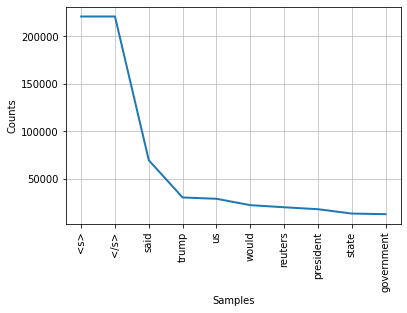

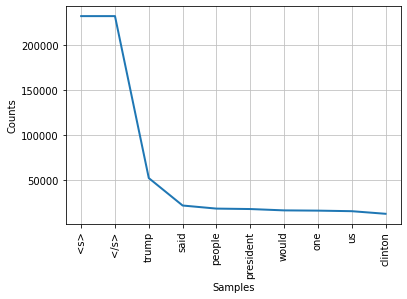

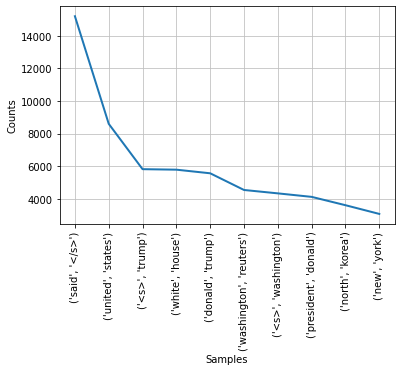

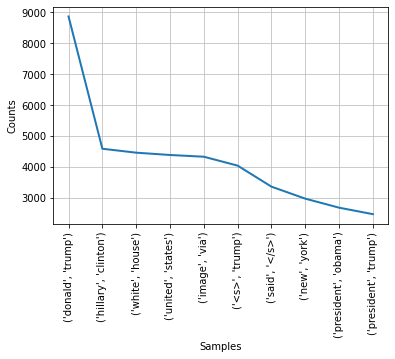

In [ ]:
# TODO: observations/statistics
import nltk
import nltk.tokenize as tk
import sklearn.feature_extraction.text as ft
import sklearn.preprocessing as sp

uni_bow_real = nltk.FreqDist(processed_real_news_training) #freq real dict for uni bow


bi_bow_real = nltk.FreqDist(nltk.bigrams(processed_real_news_training))


uni_bow_fake = nltk.FreqDist(processed_fake_news_training)  #freq fake dict for uni bow


bi_bow_fake = nltk.FreqDist(nltk.bigrams(processed_fake_news_training))


uni_bow_real_len = len(uni_bow_real)
bi_bow_real_len = len(bi_bow_real) 

uni_bow_fake_len = len(uni_bow_fake)
bi_bow_fake_len = len(bi_bow_fake)

uni_bow_real.plot(10,cumulative=False)
uni_bow_fake.plot(10,cumulative=False)
bi_bow_real['</s>', '<s>'] = 0
bi_bow_fake['</s>', '<s>'] = 0
bi_bow_real.plot(10,cumulative=False)
bi_bow_fake.plot(10,cumulative=False)

#from nltk.collocations import *
#bigram_measures = nltk.collocations.BigramAssocMeasures()
#finder = BigramCollocationFinder.from_words(unstopped)
#sorted(finder.nbest(bigram_measures.raw_freq, 10))


In [ ]:
bi_bow_real

**Please answer the following question**:

**Q1.2: What did you do in your preprocessing part?**

Your answer:

A: We tokenized and lowercased all the words.

B: We found the 's following the letters and replace with space.

C: We found the punctuation and replace with empty space.

D: We found the abbreviation of not, would, will, am, are, have and replace with its orginal form.

E: We replaced some numbers.

F: We replaced some symbols.

G: We filtered with the stop words.

H: We did stemmer, and change the word to its orgin form.


# Part 2: Compute Unsmoothed Language Models.

To start, you will write a program that computes unsmoothed unigram and bigram probabilities. You should consider real and fake news as separate corpora and
generate a separate language model for each set of news.
We have already loaded the data and (partially) preprocessed it and you probably did some of your own preprocessing. 

Note that you were allowed to use existing
tools for the purpose of preprocessing, but you must write the code for gathering n-gram counts and computing n-gram probabilities yourself. 

For example, consider the
simple corpus consisting of the sole sentence:


> the students liked the assignment

Part of what your program would compute for a unigram and bigram model, for example,
would be the following:


> $P("the") = 0.4; P("liked") = 0.2; P("the"|"liked") = 1.0; P("students"|"the") = 0.5$

Remember to add a symbol to mark the beginning of sentence. See Sept. 7th lecture, p25-28 for an example.




**Advice**: jupyter notebooks (including colab) can be a double-edged sword. It's amazing and liberating to just start writing code and run it by simply running a cell. However, it gets messy very quickly. So, once you're done prototyping, we highly recommend using functions (classes may be unnecessary but go for it if you want) to make things cleaner and easier to debug.

## 2.1 Unsmoothed Uni-gram Model.

In this part of the project, you are trying to compute the probabilities for a unigram model. You might want to take in a list of words, and return the probabilities for each
occurence. Think of an efficient data structure to use here given what ratio of reads and puts you expect.

Please look at the example above and consider how we get the probabilities.

Below is a starter point you can go from, but you DO NOT need to stick it. Feel free to use your own design.

In [ ]:
"""
Reference code for start. You do not need to follow this.
Function [unsmoothed_unigram] computes the probabilities for a unigram model
lst: a list of words in a sentence
Return: [data structure of your choice] that stores the result
"""

def unsmoothed_unigram(lst):
  # Getting a list and return two probabilites
  # One for the probability of the real news
  # One for the probability of the fake news.

  # !!!!!!! Preproces the lst_token as well
  # ?????? Do we also times the probability of the start sentence token?
  #lst_token = [list(map(str.lower, word_tokenize(sent))) for sent in sent_tokenize(lst)]
  # Don't need to do the step above as the list of words means the sentence is already tokenized

  #lst_token = nltk.FreqDist(lst)  # Store unique words and its count 
  #sb_stemmer = sb.SnowballStemmer('english') 
  bow_freqdist_real= nltk.FreqDist(processed_real_news_training)
  bow_freqdist_fake= nltk.FreqDist(processed_fake_news_training)

  unsmoothed_unigram_probability_real = 1
  unsmoothed_unigram_probability_fake = 1

  for x in range(0, len(lst)):
    freqOfWord_real=bow_freqdist_real[lst[x]]
    freqOfWord_fake=bow_freqdist_fake[lst[x]]

    unsmoothed_unigram_probability_real=unsmoothed_unigram_probability_real*(freqOfWord_real/len(processed_real_news_training))
    unsmoothed_unigram_probability_fake=unsmoothed_unigram_probability_fake*(freqOfWord_fake/len(processed_fake_news_training))

  return unsmoothed_unigram_probability_real,unsmoothed_unigram_probability_fake



## 2.2 Unsmoothed Bi-gram Model.

In this part of the project, you are trying to compute the probabilities for a bigram model. You can approach this with similar methods as above.

Remember the definition:
$p(w_n\mid w_{n-1})=\frac{C(w_{n-1}w_n)}{C(w_{n-1})}$ this means you might want to store two things (count of $w_{n-1}$ and count of $w_{n-1}w_n$).

In [ ]:
# TODO: Add code for bigram probability calculation. 

def unsmoothed_bigram(lst):

  unsmoothed_bigram_probability_real=1
  unsmoothed_bigram_probability_fake=1


  uni_bow_real = nltk.FreqDist(processed_real_news_training)
  bi_bow_real = nltk.FreqDist(nltk.bigrams(processed_real_news_training))   

  uni_bow_fake = nltk.FreqDist(processed_fake_news_training)
  bi_bow_fake = nltk.FreqDist(nltk.bigrams(processed_fake_news_training))   
  # from nltk.util import ngrams

  #count_start_real=uni_bow_real['<s>']
  #count_start_firstWord_real=uni_bow_real['<s>',lst[0]]
  #unsmoothed_bigram_probability_real=unsmoothed_bigram_probability_real*(count_start_firstWord_real/count_start_real)

  #count_start_fake=uni_bow_fake['<s>']
  #count_start_firstWord_fake=uni_bow_fake['<s>',lst[0]]
  #unsmoothed_bigram_probability_fake=unsmoothed_bigram_probability_fake*(count_start_firstWord_fake/count_start_fake)
  
  for x in range(1, len(lst)):
    count_1_real=uni_bow_real[lst[x-1]]
    count_2_real=bi_bow_real[lst[x-1],lst[x]]
    unsmoothed_bigram_probability_real=unsmoothed_bigram_probability_real*((count_2_real)/(count_1_real))
    print(unsmoothed_bigram_probability_real)

    count_1_fake=uni_bow_fake[lst[x-1]]
    count_2_fake=bi_bow_fake[lst[x-1],lst[x]]
    unsmoothed_bigram_probability_fake=unsmoothed_bigram_probability_fake*((count_2_fake)/(count_1_fake))
    print(unsmoothed_bigram_probability_fake)


  return unsmoothed_bigram_probability_real,unsmoothed_bigram_probability_fake

sample_2 = ['<s>','london','(']
unsmoothed_bigram(sample_2)

In [ ]:
uni_bow_real['<s>']


**Please answer the following question**:

**Q2: What data structure are you using to store probabilities for unigrams and bigrams? Why did you select this data structure?**

Your answer:


nltk.FreqDist was used to store probabilites. FreqDist is a subclass of dict in python, where the key and corresponding value can be saved simultaneously. 

We used the data structure because it returns the list of "unique" words and its count. We can easily find the count of a specific word in the corpus with given word.



# Part 3: Smoothed Language Model
In this part, you will need to implement **at least one** smoothing method and **at least one** method to handle unknown words in the test data. You can choose any method(s) that you want for each. You should make clear
**what method(s)** were selected and **why**, providing a description for any non-standard approach (e.g., an approach that was not covered in class or in the readings). 

You should use the
provided validation sets to experiment with different smoothing/unknown word handling
methods if you wish to see which one is more effective for this task. (We will cover this in Part 4).

## 3.1 Unknown Words Handling

**Please answer the following questions:**

**Q3.1: How are you going to handle unknown words? What parameters might be needed? Do you need a method to determine the value?**

Since we are treating this problem as an open vocabulary problem. Adding UNK tokens to the dictionary based on word's frequency is a better option. We will replace by <UNK> for all words that occur fewer than n times in the training set. We can use cross-validaiont to determine the number n. However, in our cases, it is better to choose the number n by perplexities. We finally choose choose n = 1 and mark the work with freq=1 to "《unk》".


In [ ]:

uni_bow_real = nltk.FreqDist(processed_real_news_training) #freq real dict for uni bow


bi_bow_real = nltk.FreqDist(nltk.bigrams(processed_real_news_training))


uni_bow_fake = nltk.FreqDist(processed_fake_news_training)  #freq fake dict for uni bow


bi_bow_fake = nltk.FreqDist(nltk.bigrams(processed_fake_news_training))
print(uni_bow_real['<unk>'])

0


24798


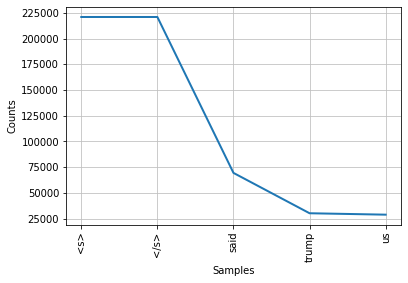

76391


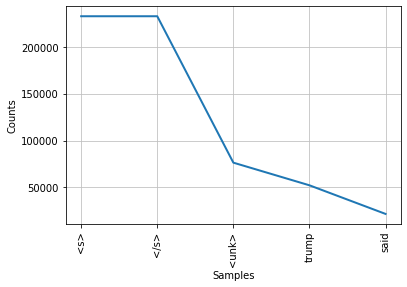

43002
74915


In [ ]:
# TODO: Add your unknown word handling code 
#


def handle_unk(dist):
  new_dict = dist.copy()
  new_dict['<unk>'] = 0
  res = 0
  for k in list(new_dict.keys()):
    if (new_dict[k] == 1): # convert all freq to 1 to UNK
      new_dict.pop(k)
      res = res + 1
      continue
  #print(res)
  new_dict['<unk>'] = res
  return new_dict


uni_bow_real = handle_unk(uni_bow_real)
uni_bow_fake = handle_unk(uni_bow_fake)
bi_bow_real = handle_unk(bi_bow_real)
print(uni_bow_real['<unk>'])
uni_bow_real.plot(5,cumulative=False)
bi_bow_fake = handle_unk(bi_bow_fake)
print(uni_bow_fake['<unk>'])
uni_bow_fake.plot(5,cumulative=False)

uni_bow_real_len = len(uni_bow_real)
bi_bow_real_len = len(bi_bow_real) 

uni_bow_fake_len = len(uni_bow_fake)
bi_bow_fake_len = len(bi_bow_fake)

print(len(uni_bow_real))
print(len(uni_bow_fake))

## 3.2 Smoothing

In this part of project, we are going to compute the probabilities for unigram and bigram models after smoothing.
There are several smoothing methods you can start with:
* add-k
* Kneser-Ney
* Good-Turing
* ...

You need to compute for both unigram and bigram models.

Below is a starter point using add-k smoothing. As always, you DO NOT need to follow it; you DO NOT need to use add-k smoothing if you do not want to. You can pick ANY smoothing method you want.

In [ ]:
"""
Reference code for add-k smoothing on unigram model.
dic: a dictionary of your unigrams. key: words, val: occurence
k: parameter k for smoothing
Return: a dictionary of results after smoothing
"""


def add_k_unigram(lst,k):
  # Getting a list and return two probabilites
  # One for the probability of the real news
  # One for the probability of the fake news.

  # !!!!!!! Preproces the lst_token as well
  # ?????? Do we also times the probability of the start sentence token?
  #lst_token = [list(map(str.lower, word_tokenize(sent))) for sent in sent_tokenize(lst)]
  # Don't need to do the step above as the list of words means the sentence is already tokenized


  #lst_token = nltk.FreqDist(lst)  # Store unique words and its count 
  #sb_stemmer = sb.SnowballStemmer('english') 
  #bow_freqdist_real= nltk.FreqDist(processed_real_news_training)
  #bow_freqdist_fake= nltk.FreqDist(processed_fake_news_training)

  unsmoothed_unigram_probability_real = 1
  unsmoothed_unigram_probability_fake = 1

  for x in range(0, len(lst)):
    # word=lst[x]
    # if word in uni_bow_real:
    #   freqOfWord_real=uni_bow_real[word]
    # else:
    #    freqOfWord_real=k 
    # if word in uni_bow_fake:
    #   freqOfWord_fake=uni_bow_fake[word]
    # else:
    #    freqOfWord_fake=k 
    word=lst[x]
    if word in uni_bow_real:
      freqOfWord_real=uni_bow_real[word]
    else:
       freqOfWord_real=0 
    if word in uni_bow_fake:
      freqOfWord_fake=uni_bow_fake[word]
    else:
       freqOfWord_fake=0 

    unsmoothed_unigram_probability_real=unsmoothed_unigram_probability_real*(((freqOfWord_real)+(k))/((len(processed_real_news_training))+(uni_bow_real_len*k)))
    unsmoothed_unigram_probability_fake=unsmoothed_unigram_probability_fake*(((freqOfWord_fake)+(k))/((len(processed_fake_news_training))+(uni_bow_fake_len*k)))
    
  return unsmoothed_unigram_probability_real,unsmoothed_unigram_probability_fake

add_k_unigram(['said'],1)


(0.01784287958606143, 0.005013495212903603)

In [ ]:
"""
Reference code for add-k smoothing on bigram model.
uni_dic: a dictionary of your unigrams.
bi_dic: a dictionary of your bigrams.
k: parameter k for smoothing
Return: a dictionary of results after smoothing
"""
def add_k_bigram(lst,k):

  unsmoothed_bigram_probability_real=1
  unsmoothed_bigram_probability_fake=1
 
  # from nltk.util import ngrams

  #count_start_real=uni_bow_real['<s>']
  #count_start_firstWord_real=uni_bow_real['<s>',lst[0]]
  #unsmoothed_bigram_probability_real=unsmoothed_bigram_probability_real*(count_start_firstWord_real/count_start_real)

  #count_start_fake=uni_bow_fake['<s>']
  #count_start_firstWord_fake=uni_bow_fake['<s>',lst[0]]
  #unsmoothed_bigram_probability_fake=unsmoothed_bigram_probability_fake*(count_start_firstWord_fake/count_start_fake)

  for x in range(1, len(lst)):
    if lst[x-1] in uni_bow_real:
      count_1_real=uni_bow_real[lst[x-1]]
    else:
      count_1_real=0

    if lst[x-1] in uni_bow_fake:
      count_1_fake=uni_bow_fake[lst[x-1]]
    else:
      count_1_fake=0
    
    if (lst[x-1],lst[x]) in bi_bow_real:
      count_2_real=bi_bow_real[lst[x-1],lst[x]]
    else:
      count_2_real=0

    if (lst[x-1],lst[x]) in bi_bow_fake:
      count_2_fake=bi_bow_fake[lst[x-1],lst[x]]
    else:
      count_2_fake=0

    unsmoothed_bigram_probability_real=unsmoothed_bigram_probability_real*((count_2_real+k)/(count_1_real+uni_bow_real_len*k))
    #print(unsmoothed_bigram_probability_real)

    unsmoothed_bigram_probability_fake=unsmoothed_bigram_probability_fake*((count_2_fake+k)/(count_1_fake+uni_bow_fake_len*k))
    #print(unsmoothed_bigram_probability_fake)


  return unsmoothed_bigram_probability_real,unsmoothed_bigram_probability_fake
add_k_bigram(['news','us','vote','also'],0.5)

(7.608029745328732e-12, 3.7632986698237416e-12)

**Please answer the following question:**

**Q3.2: Which smoothing method did you choose? Are there any parameters, if so how are you planning to pick the value? If you choose to implement more than 1 method (not a requirement), please state each of them. Providing a description for any non-standard approach, e.g., an approach that was not covered in class or in the readings**
Your answer:

Add k-smoothing.

K is the parameter.

We only used k-smoothing for our model selection.

We are planning to choose k based on the validation set performance. We will optimize the perplexity value based on the validation set from where k ranges from (0.025, 0.05, 0.5, 1, 20)

According to the perplexity eqation, the smaller the perplexity value, the larger the probability of of the given input sentences. We want to pick the k value that's going to give us the smallest perplexity value. We know the k value is essential, but according to our intuition, and later validation from the experiment, we know that the the k can not be too big either. The big k value can introduce unnecessary noise to the data. The small yet apporpriate k value provides buffer for unseen word situration without adding too much error on purpose.

Based on our data:
For the real news: k in (0.025, 0.05, 0.5, 1, 20)
For the real news: PP in (2420,1583,3111,4086,12709 )

For the fake news: k in (0.025, 0.05, 0.5, 1, 20)
For the fake news: PP in (5927,3729,9879,7609,27920 )

So we pick 0.025 as our k values for both real and fake news, as it both introduces lowest perplexity

# Part 4: Perplexity
At this point, we have developed several language models: unigram vs bigram, unsmoothed vs smoothed. We now want to compare all the models. 

Implement code to compute the perplexity of a **“development set.”** (“Development set”
is just another way to refer to the validation set—part of a dataset that is distinct from
the training portion and the test portion.) Compute and report the perplexity of each
of the language models (one trained on true news and fake news) on
the development corpora. Compute perplexity as follows:
\begin{align*}
PP &= \left(\prod_i^N\frac{1}{P\left(W_i\mid W_{i-1}, ...W_{i-n+1}\right)}\right)^{\frac{1}{N}}\\
&=\exp \frac{1}{N}\sum_{i}^N-\log P\left(W_i\mid W_{i-1}, ...W_{i-n+1}\right)
\end{align*}
where $N$ is the total number of tokens in the test corpus and $P\left(W_i\mid W_{i-1}, ...W_{i-n+1}\right)$
is the n-gram probability of your model. Under the second definition above, perplexity
is a function of the average (per-word) log probability: use this to avoid numerical
computation errors.

Please complete the following tasks and report what you have observed. Remember, lower perplexity means better model.

## Task 1: Compute perplexity for smoothed unigram and smoothed bigram. 

*   List item
*   List item


*Note: If you choose more than one smoothing method, pick one of them to compute. If you need to try different values of parameters, you can try them out here.*

In [ ]:
# compute perplexity for unsmoothed unigram and unsmoothed bigram
# TODO: compute perplexity for one smoothing method on unigram, and one smoothing method on bigram.
# Remeber to import np

import numpy as np
import math
def find_Uni_pp(lst,k):
  n=len(lst)
  log_total_real=0
  log_total_fake=0
  
  for x in range(0, n):
    word=lst[x]
    if word in uni_bow_real:
      freqOfWord_real=uni_bow_real[word]
    else:
       freqOfWord_real=0 
    if word in uni_bow_fake:
      freqOfWord_fake=uni_bow_fake[word]
    else:
       freqOfWord_fake=0 
    p_real=((freqOfWord_real)+(k))/((len(processed_real_news_training))+(uni_bow_real_len*k))
    p_fake=((freqOfWord_fake)+(k))/((len(processed_fake_news_training))+(uni_bow_fake_len*k))
    log_total_real=log_total_real+np.log(p_real)
    log_total_fake=log_total_fake+np.log(p_fake)

  Uni_pp_real=math.exp((1/n)*(-log_total_real))
  Uni_pp_fake=math.exp((1/n)*(-log_total_fake))

  return Uni_pp_real,Uni_pp_fake



def find_bi_pp(lst,k):
  n=len(lst)
  log_total_real=0
  log_total_fake=0

  for x in range(1, n):

    if lst[x-1] in uni_bow_real:
      count_1_real=uni_bow_real[lst[x-1]]
    else:
      count_1_real=0

    if lst[x-1] in uni_bow_fake:
      count_1_fake=uni_bow_fake[lst[x-1]]
    else:
      count_1_fake=0
    
    if (lst[x-1],lst[x]) in bi_bow_real:
      count_2_real=bi_bow_real[lst[x-1],lst[x]]
    else:
      count_2_real=0

    if (lst[x-1],lst[x]) in bi_bow_fake:
      count_2_fake=bi_bow_fake[lst[x-1],lst[x]]
    else:
      count_2_fake=0

    p_real=(count_2_real+k)/(count_1_real+uni_bow_real_len*k)
    p_fake=(count_2_fake+k)/(count_1_fake+uni_bow_fake_len*k)
    log_total_real=log_total_real+np.log(p_real)
    log_total_fake=log_total_fake+np.log(p_fake)

  Bi_pp_real= math.exp((1/n)*(-log_total_real))
  Bi_pp_fake= math.exp((1/n)*(-log_total_fake))

  return Bi_pp_real,Bi_pp_fake


# We are finding the pp for two models: 1. smoothed unigram 2. smoothed bigram
# Given the list, find_pp() returns the pp for both models
# k is how many degree of smoothing
# Each models have two pp, so we return 4 pp in total
def find_pp(lst,k):
  Uni_pp_real,Uni_pp_fake = find_Uni_pp(lst,k)
  Bi_pp_real,Bi_pp_fake=find_bi_pp(lst,k)
  return Uni_pp_real,Uni_pp_fake,Bi_pp_real,Bi_pp_fake

uni_bow_real_v = nltk.FreqDist(processed__real_news_validation)
print(find_bi_pp(processed__real_news_validation,0.5))
print(find_bi_pp(processed__fake_news_validation,0.5))
print(find_bi_pp(processed__real_news_validation,1))
print(find_bi_pp(processed__fake_news_validation,1))
print(find_bi_pp(processed__real_news_validation,0.25))
print(find_bi_pp(processed__fake_news_validation,0.25))
print(find_bi_pp(processed__real_news_validation,0.05)) #optimal solution
print(find_bi_pp(processed__fake_news_validation,0.05)) #optimal solution
print(find_bi_pp(processed__real_news_validation,20))
print(find_bi_pp(processed__fake_news_validation,20))

(3111.9987058946745, 9392.25391586616)
(8188.215208716934, 7609.211851934598)
(4086.878797409328, 11606.96192951039)
(9502.650392746209, 9879.902860261245)
(2420.5198518386883, 7714.589483879973)
(7183.915968774366, 5927.093565084987)
(1583.3771638903927, 5502.56134835783)
(6048.750440334126, 3729.7550536761005)
(12709.365120330493, 27920.58445064995)
(18345.604872877328, 27165.693549735402)


**Q4.1: Why do we need to compute perplexity after smoothing?**

Your answer:

Without smoothing, for unseen words in the dataset, the term "𝑃(𝑊𝑖∣𝑊𝑖−1,...𝑊𝑖−𝑛+1)" could be zero for both bigram and unigram models. The perplexity term "1/(𝑃(𝑊𝑖∣𝑊𝑖−1,...𝑊𝑖−𝑛+1))" will be undefined for those whose P are 0. 

So to ensure the perplexity value is valid, we do smoothing before the calculation.

**Q4.2: Did you choose any values for parameters?**

Your answer:

We chose k(the degree of smoothing) as our parameter here. With differnet value of k, both unigram and bigram models are smoothed differently, the term "𝑃(𝑊𝑖∣𝑊𝑖−1,...𝑊𝑖−𝑛+1)" will also be differnt with differnt ks.

By adding k as our parameter, we can determine how differnet smoothings affect the perplexity of each model, which will help to pick the best smoothting parameter for our model.

## Task 2: Compute perplexity for other smoothing methods (optional). 
*Note: If you only pick one smoothing method, you can omit this task. If you need to try different values of parameters, you can try them out here.*


In [ ]:
# TODO: compute perplexity for one smoothing method on unigram, and one smoothing method on bigram.


**Q4.3: If your smoothing method needs to pick a parameter, what is the value of your parameter?**

Your answer:

**Q4.4: Which smoothing method is the best among your choices?**

Your answer:

# Part 5: Putting Everything Together and Submitting to Kaggle
Combining all the previous parts together, we have developed a bunch of language models. Before we proceed to the next step, let's check a few things (no need to answer):
* Did you train your model only on training set?
* Did you validate your model only on validation/development set?
* Did you determine all your parameters?

Finally, please answer:

**Q5: What is your choice of language model, and why?**

Your answer:
* We have trained our model only on the traning set.

* We make sure to validate the adjust our parameter k using the validation data set. 

* Since we used only one smoothing method - add k smoothing:We had ony one parameter k where we have optmized using the validation data set.

* We have decied to use bigram model with k being 0.05. From the theory's stand point, bigram  has provided more background knowledge of the data to the model. Comparing to unigram model, bigram model has give more of word meaning and also continuity of the english language. Giving the model more specific data of what word what makes more sense from statistic's standpoint. This has also supported by our data, showing bigram model performs a little better, under the assumption that we have a huge training dataset.




In [ ]:
# TODO: anything that helps you answer/check the above points.
with io.open(os.path.join(dataset_path, "TestData.txt"), encoding='utf8') as real_file:
  test_data = real_file.read()
delimiter = "\n"
paras = test_data.split(delimiter)
tokenized_test = [list(map(str.lower, word_tokenize(abbreviations_process(para)))) for para in paras]


In [ ]:
tokenized_test[0:5]

for i in range(0,len(tokenized_test)):
  tokenized_test[i] = filter_s(tokenized_test[i])

In [ ]:
tokenized_test[4489]

## Part 5.1: First Model Submission to Kaggle

Now we need to apply our model to testing data. What you need to do:
* Takes the test data as input, and generates an output of your prediction based on your chosen language model
* Your output file should be ONLY your predictions
* Submit to Kaggle

You should use your trained model to predict labels for all the news in `TestData.txt`. Output your predictions to a **csv** file and submit it to kaggle. Each line should contain the id of the test news and its corresponding prediction (in total 4489 lines). In other words, your output should look like (**including the header**):
```
Id,Prediction
0,0
1,0
2,1
3,0
...
4488,1
```
Note that you should add the header `Id,Prediction` and there is no space in the output. The Id starts from 0 (not 1).

Use this kaggle [link](https://www.kaggle.com/t/a032d54898b24b4bb2f29e7165ac5fdf) to submit your output. Your team name should be the concatenation of your netids, **exactly in the same order as this notebook is named**. For example, if notebook is 4740_FA20_p1_jb123_cj456, then Kaggle group should be jb123_cj456.


In [ ]:
# TODO: Add code to generate the Kaggle output file and submit the output file to Kaggle
#res=[2,len(tokenized_test)]
#for i in range(0, len(tokenized_test)):
  #  res[0][i],res[1][i] = add_k_unigram(tokenized_test[i],1)
 #   res1[0][i],res[1][i] = add_k_bigram(tokenzied_test[i],0.05)
import pandas as pd

column_namnes=['a','b','c','d']
df=pd.DataFrame(columns=column_namnes)
res= []
res1 = []
res2 = []
res4 = []
for i in range(0, len(tokenized_test)):
  if (len(tokenized_test[i])==0):
    res.append(1)
    res1.append(0)
    res2.append(1)
    res4.append(0)
  else:

    res_num,res1_num = find_Uni_pp(tokenized_test[i],1)
    res2_num,res4_num= find_bi_pp(tokenized_test[i],0.05)
    res.append(res_num)
    res1.append(res1_num)
    res2.append(res2_num)
    res4.append(res4_num)



In [ ]:
len(label)

4490

In [ ]:
label=[]
for i in range(0, len(res2)):
  if (res2[i]<res4[i]):
    label.append(1)
  else:
    label.append(0)
print(label)

import csv
names = ['label']
test=pd.DataFrame(columns=names,data=label)
#rows=label
test.to_csv(os.path.join(dataset_path, "label.csv"),encoding='gbk')


  


In [ ]:
#len(tokenized_test)
tokenized_test[60000]

# Part 6: Naive Bayes

The Naive Bayes classification method is based on Bayes Rule. Suppose we have a news article *d* and its label *c* (either 0 or 1).
\begin{align*}
P(c|d)=\frac{P(d|c)P(c)}{P(d)}
\end{align*}
Likelihood: $P(d|c)$. In real/fake corpus, how likely *d* would appear.

Prior: $P(c)$. The probability of real/fake news in general.

Posterior: $P(c|d)$. Given *d*, how likely is it that it is real/fake.

Goal: $\underset{c\in \{0,1\}}{\operatorname{argmax}} P(c|d)$, which is equivalent to $\underset{c\in \{0,1\}}{\operatorname{argmax}} P(d|c)P(c)$.

The equivalence holds because $P(d)$ is the same for any $c$. Thus the denominator can be dropped.

Denote $d=\{x_1, x_2, ..., x_n\}$ where $x_i$'s are words in the news *d* (sometimes called features). Unlike n-gram language modelling, we make the multinomial Naive Bayes independence assumption here, where we assume positions of words do not matter. Formally, 
\begin{align*}
&\underset{c\in \{0,1\}}{\operatorname{argmax}} P(d|c)P(c)\\
=&\underset{c\in \{0,1\}}{\operatorname{argmax}} P(x_1, ..., x_n|c)P(c)\\
=&\underset{c\in \{0,1\}}{\operatorname{argmax}} P(x_1|c)P(x_2|c)...P(x_n|c)
\end{align*}

Now we only need to collect the occurences of each word for the classification. This is often called a **bag of words** feature. 

For instance, in the sentence `All for one and one for all .`, the bag of words feature would be `{"all": 2, "for": 2, "one": 2, "and": 1, ".": 1}`. Essentially, the bag of words feature is a dictionary which maps the word to its occurences. We can see that the order is not considered here.

Now, your goal is to implement the Multinomial Naive Bayes. You can use existing codes or Python packages, and adapt them to our news classification task.

You might find the following packages/functions useful:

* nltk.word_tokenize(), nltk.word_tokenize()
* nltk.classify.naivebayes()
* sklearn.feature_extraction.text
* sklearn.naive_bayes.MultinomialNB()

**Please answer the following question(s).**

**Q6: Comparing Multinomial Naive Bayes with the unigram language model, which one do you expect to perform better? Why?**

A: 

In therory: Naive Bayes should have a more accurate perforamnce.


Here shows the Navie Bayes model:
\begin{align*}
&\underset{c\in \{0,1\}}{\operatorname{argmax}} P(d|c)P(c)\\
=&\underset{c\in \{0,1\}}{\operatorname{argmax}} P(x_1, ..., x_n|c)P(c)\\
\end{align*}
The term "P(x_1, ..., x_n|c)" is probabily of a given input data with respect to c class, which is the same as unigram model's probabily as respect to c class. 

So the extra term P(c) in Navie Bayes model differntiate between the two models. The term P(C) gives prior and background knowlege of the class, which gives more context to the model. Thus, in theory, naive bayes model should perform better.

## 6.1 Implementation

In [ ]:

# Getting the dataframes for the training data of real and fake news combined in one dataframe 
def get_df_train():
  real_news_list = sent_tokenize(real_news)   # Obtain the list of news including the puncuations
  df_real = pd.DataFrame (real_news_list,columns=['news']) # converting the list into the dataframe
  df_real['label'] = 1      # adding a column, show the label of these real news are 1
  
  fake_news_list = sent_tokenize(fake_news)
  df_fake = pd.DataFrame (fake_news_list,columns=['news'])
  df_fake['label'] = 0

  df_train=pd.concat([df_real, df_fake], ignore_index=True)
  return df_train


# Getting the validation data
def get_df_validation():
  real_news_list = sent_tokenize(real_news_validation)   
  df_real = pd.DataFrame (real_news_list,columns=['news']) 
  df_real['label'] = 1      
  
  fake_news_list = sent_tokenize(fake_news_validation)
  df_fake = pd.DataFrame (fake_news_list,columns=['news'])
  df_fake['label'] = 0

  df_validaton=pd.concat([df_real, df_fake], ignore_index=True)
  return df_validaton




## 6.2 Putting Everything Together and Submitting to Kaggle

You should use your trained model to predict labels for all the news in `TestData.txt`. Output your predictions to a **csv** file and submit it to kaggle. The format should follow Part 6 as well.

Use this Kaggle [link](https://www.kaggle.com/t/e8e4f7ee507843d1902c168529d705c8) to submit your output.

In [ ]:
# TODO: Code for predicting the test labels and generating the output file. Then submit the output file to Kaggle
def out_put_NB_csv():

  with io.open(os.path.join(dataset_path, "TestData.txt"), encoding='utf8') as real_file:
    test_data = real_file.read()
  delimiter = "\n"
  paras = test_data.split(delimiter)

  df_train = get_df_train()
  x_train= df_train['news']
  y_train= df_train['label']
  x_validation=paras

  counter_vectorizer = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, stop_words='english')
  x_train_cv = counter_vectorizer.fit_transform(x_train)
  x_validation_cv = counter_vectorizer.transform(x_validation)

  nb_model = MultinomialNB()
  nb_model.fit(x_train_cv, y_train)
  validation_projection=nb_model.predict(x_validation_cv)

  # import csv
  names = ['label']
  test=pd.DataFrame(columns=names,data=validation_projection)
  test.to_csv(os.path.join(dataset_path, "NB.csv"),encoding='gbk')

out_put_NB_csv()

# Work Distribution

**Please briefly describe how you divided the work.**

Your answer:

Zhao: 
Processed the dataset, helped debuging problems within smoothed models, caluculated perplexity together with shen,worked on putting everything together, tested and found a optimal n-gram models, finsihed and sumitted everything together

Shen:
Computed smoothed and unsmoothed unigram and bigram models,caluculated perplexity together with Zhao, implemented naive bayes, helped with finding optimal n-gram models, finsihed and sumitted everything together




# Project Feedback [1 point]
It goes without saying that this is an unprecedented time. We on the course staff are trying our best to adapt our teaching, projects and everything else in the class to this new modality. We would immenselly appreciate it if you could provide us feedback (it's a super short form!!) on this project and **it's worth 1 point of your project grade**

Link to the feedback form: https://forms.gle/xfonP9rJk9Uk7zaSA 

We will use this feedback to improve both **upcoming projects** and projects for next year. 

Thank you so much!

# Submitting the Notebook

1. Go to File (upper left corner) -> Download .ipynb -> submit this downloaded file to cms
2. Run the first code block
3. Replace our placeholder for your correct Google Drive directory structure in the 2nd code block below. Run the code block
4. Put the name of this notebook into our placeholder in the 3rd code block. Run the code block
5. Then go to the folder icon on the very left panel, under the orange CO logo. Click on the folder and wait for a PDF version of your notebook to appear. Might take a few minutes.
6. Download the pdf version and submit to Gradescope

In [ ]:
%%capture
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
%%capture
# the red text is a placeholder! Change it to your directory structure!
!cp 'drive/My Drive/Colab Notebooks/4740_FA20_p1_sc2993_tz424_new.ipynb' ./ 

In [ ]:
# the red text is a placeholder! Change it to the name of this notebook!
!jupyter nbconvert --to PDF "4740_FA20_p1_sc2993_tz424_new.ipynb"

[NbConvertApp] Converting notebook 4740_FA20_p1_sc2993_tz424_new.ipynb to PDF
[NbConvertApp] Support files will be in 4740_FA20_p1_sc2993_tz424_new_files/
[NbConvertApp] Making directory ./4740_FA20_p1_sc2993_tz424_new_files
[NbConvertApp] Making directory ./4740_FA20_p1_sc2993_tz424_new_files
[NbConvertApp] Making directory ./4740_FA20_p1_sc2993_tz424_new_files
[NbConvertApp] Making directory ./4740_FA20_p1_sc2993_tz424_new_files
[NbConvertApp] Making directory ./4740_FA20_p1_sc2993_tz424_new_files
[NbConvertApp] Making directory ./4740_FA20_p1_sc2993_tz424_new_files
[NbConvertApp] Writing 133242 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 200970 bytes to 4740_FA20_p1_sc2993_tz424_n

# You are done! ✅